In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import b3d
from jax.scipy.spatial.transform import Rotation as Rot
from b3d import Pose
#from b3d.utils import unproject_depth
import rerun as rr
import genjax
from tqdm import tqdm

rr.init("demo.py")
rr.connect("127.0.0.1:8812")
#rr.save('multi_particle_visualization_physics_constrained.rrd')


In [2]:
width=128
height=128
fx=64.0
fy=64.0
cx=64.0
cy=64.0
near=0.001
far=16.0
renderer = b3d.Renderer(
    width, height, fx, fy, cx, cy, near, far
)

In [3]:
def rotation_from_axis_angle(axis, angle):
    """Creates a rotation matrix from an axis and angle.

    Args:
        axis (jnp.ndarray): The axis vector. Shape (3,)
        angle (float): The angle in radians.
    Returns:
        jnp.ndarray: The rotation matrix. Shape (3, 3)
    """
    sina = jnp.sin(angle)
    cosa = jnp.cos(angle)
    direction = axis / jnp.linalg.norm(axis)
    # rotation matrix around unit vector
    R = jnp.diag(jnp.array([cosa, cosa, cosa]))
    R = R + jnp.outer(direction, direction) * (1.0 - cosa)
    direction = direction * sina
    R = R + jnp.array(
        [
            [0.0, -direction[2], direction[1]],
            [direction[2], 0.0, -direction[0]],
            [-direction[1], direction[0], 0.0],
        ]
    )
    return R

def transform_from_rot(rotation):
    """Creates a pose matrix from a rotation matrix.

    Args:
        rotation (jnp.ndarray): The rotation matrix. Shape (3, 3)
    Returns:
        jnp.ndarray: The pose matrix. Shape (4, 4)
    """
    return jnp.vstack(
        [jnp.hstack([rotation, jnp.zeros((3, 1))]), jnp.array([0.0, 0.0, 0.0, 1.0])]
    )

def transform_from_axis_angle(axis, angle):
    """Creates a pose matrix from an axis and angle.

    Args:
        axis (jnp.ndarray): The axis vector. Shape (3,)
        angle (float): The angle in radians.
    Returns:
        jnp.ndarray: The pose matrix. Shape (4, 4)
    """
    return transform_from_rot(rotation_from_axis_angle(axis, angle))



In [4]:
r_mat = transform_from_axis_angle(jnp.array([0,0,1]), jnp.pi/2)

In [5]:

vec_transform_axis_angle = jax.vmap(transform_from_axis_angle, (None, 0))
rots = vec_transform_axis_angle(jnp.array([0,0,1]), jnp.linspace(jnp.pi/4, 3*jnp.pi/4, 30))

In [6]:
mesh_path = os.path.join(b3d.get_root_path(),
    "assets/shared_data_bucket/ycb_video_models/models/003_cracker_box/textured_simple.obj")
mesh = trimesh.load(mesh_path)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

cam_inv_pose = b3d.Pose.from_position_and_target(
    jnp.array([0.15, 0.15, 0.0]),
    jnp.array([0.0, 0.0, 0.0])
).inv()


in_place_rots = b3d.Pose.from_matrix(rots)


compound_pose = cam_inv_pose @ in_place_rots #in_place_rot

rgbs, depths = renderer.render_attribute_many(
    compound_pose[:,None,...],
    object_library.vertices,
    object_library.faces,
    jnp.array([[0, len(object_library.faces)]]),
    object_library.attributes
)
#b3d.get_rgb_pil_image(rgb).save(b3d.get_root_path() / "assets/test_ycb.png")

In [7]:
class Intrinsics:
    width=128
    height=128
    fx=64.0
    fy=64.0
    cx=64.0
    cy=64.0
    near=0.001
    far=16.0

intrinsics = Intrinsics()

def unproject_depth(depth, intrinsics):
    """Unprojects a depth image into a point cloud.

    Args:
        depth (jnp.ndarray): The depth image. Shape (H, W)
        intrinsics (b.camera.Intrinsics): The camera intrinsics.
    Returns:
        jnp.ndarray: The point cloud. Shape (H, W, 3)
    """
    mask = (depth < intrinsics.far) * (depth > intrinsics.near)
    depth = depth * mask + intrinsics.far * (1.0 - mask)
    y, x = jnp.mgrid[: depth.shape[0], : depth.shape[1]]
    x = (x - intrinsics.cx) / intrinsics.fx
    y = (y - intrinsics.cy) / intrinsics.fy
    point_cloud_image = jnp.stack([x, y, jnp.ones_like(x)], axis=-1) * depth[:, :, None]
    return point_cloud_image

In [8]:
unproject_depth_vec = jax.vmap(unproject_depth, (0, None))

In [9]:
xyzs = unproject_depth_vec(depths, intrinsics)

In [10]:
from b3d import Pose

num_layers = 2048
renderer = b3d.Renderer(width, height, fx, fy, cx, cy, near, far, num_layers)
model = b3d.model_multiobject_timestep_gl_factory(renderer)
importance_jit = jax.jit(model.importance)
update_jit = jax.jit(model.update)

# Arguments of the generative model.
# These control the inlier / outlier decision boundary for color error and depth error.
#color_error, depth_error = (jnp.float32(30.0), jnp.float32(0.02))
color_error, depth_error = (jnp.float32(30.0), jnp.float32(0.01))
# TODO: explain
inlier_score, outlier_prob = (jnp.float32(50.0), jnp.float32(0.001)) # 5
# TODO: explain
color_multiplier, depth_multiplier = (jnp.float32(3000.0), jnp.float32(3000.0))


# Defines the enumeration schedule.
key = jax.random.PRNGKey(0)
# Gridding on translation only.

delta = 0.01
translation_deltas = Pose.concatenate_poses([jax.vmap(lambda p: Pose.from_translation(p))(jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-delta, delta, 11),
        jnp.linspace(-delta, delta, 11),
        jnp.linspace(-delta, delta, 11),
    ),
    axis=-1,
).reshape(-1, 3)), Pose.identity()[None,...]])
# Sample orientations from a VMF to define a "grid" over orientations.
rotation_deltas = Pose.concatenate_poses([jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0,None, None, None))(
    jax.random.split(jax.random.PRNGKey(0), 11*11*11),
    Pose.identity(),
    0.00001, 1000.0
), Pose.identity()[None,...]])
all_deltas =  Pose.stack_poses([translation_deltas, rotation_deltas])

In [11]:
model_args = b3d.model.ModelArgs(color_error, depth_error,
                            inlier_score, outlier_prob,
                            color_multiplier, depth_multiplier)

trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", cam_inv_pose.inv()),
            ("object_pose_0", Pose.identity()),
            ("object_0", 0),
            ("observed_rgb_depth_0", (rgbs[0], xyzs[0,...,2])),
            ("observed_rgb_depth_1", (rgbs[1], xyzs[1,...,2])),
        ])
    ),
    (jnp.arange(1), jnp.arange(15),model_args, object_library)
)

In [12]:
# uniform physics model helps tractability a lot! change back

In [13]:
from b3d.model import get_rendered_rgb_depth_from_trace

ro, do = get_rendered_rgb_depth_from_trace(trace)

In [14]:
for t in range(len(ro)):
    rr.set_time_sequence("frame", t)

    points = rr.Image(np.array(ro[t]))
    rr.log("im", points)

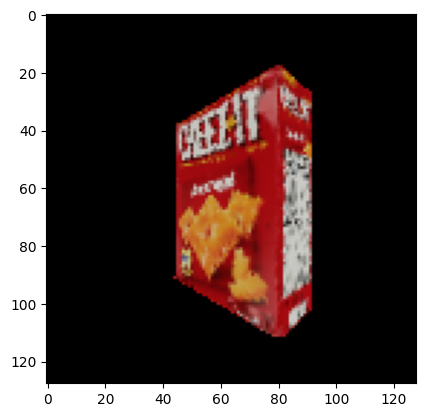

In [15]:
plt.imshow(ro[0])

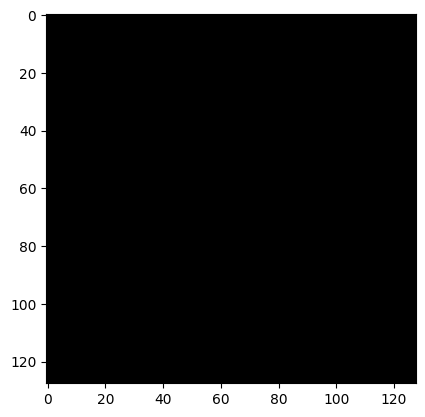

In [16]:
plt.imshow(ro[1])

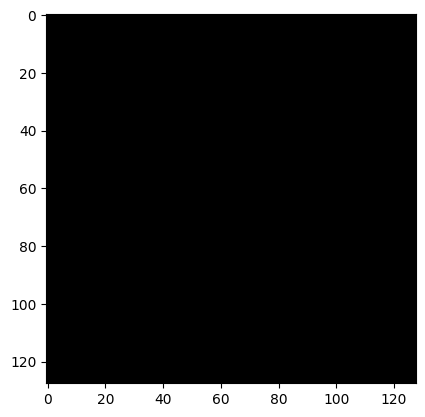

In [17]:
plt.imshow(ro[2])

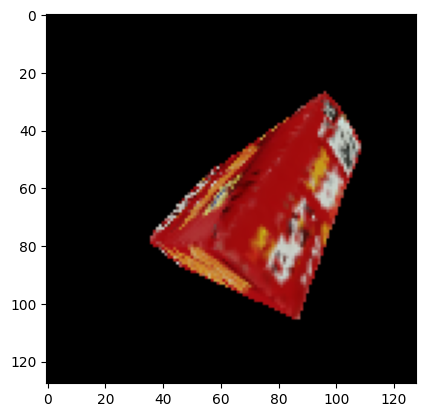

In [18]:
plt.imshow(ro[3])

In [19]:
trace['obj_0_visible_3']

Array(1, dtype=int32)

In [20]:
trace1, w1 = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", cam_inv_pose.inv()),
            ("object_pose_0", Pose.identity()),
            ("object_0", 0),
            ("observed_rgb_depth_0", (rgbs[0], xyzs[0,...,2])),
            ("observed_rgb_depth_1", (rgbs[1], xyzs[1,...,2])),
            ("obj_0_visible_1", 0)
        ])
    ),
    (jnp.arange(1), jnp.arange(2),model_args, object_library)
)

In [21]:
trace2, w2 = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", cam_inv_pose.inv()),
            ("object_pose_0", Pose.identity()),
            ("object_0", 0),
            ("observed_rgb_depth_0", (rgbs[0], xyzs[0,...,2])),
            ("observed_rgb_depth_1", (rgbs[1], xyzs[1,...,2])),
            ("obj_0_visible_1", 1)
        ])
    ),
    (jnp.arange(1), jnp.arange(2),model_args, object_library)
)

In [22]:
trace1.get_score()

Array(7698.8633, dtype=float32)

In [23]:
trace2.get_score()

Array(7106.025, dtype=float32)

In [24]:
w1,w2

(Array(7663.442, dtype=float32), Array(7070.6035, dtype=float32))

In [25]:
from b3d.model import get_poses_from_trace

get_poses_from_trace(trace)

Pose(position=Array([[0., 0., 0.]], dtype=float32), quaternion=Array([[0., 0., 0., 1.]], dtype=float32))

In [26]:
trace["obj_0_delta_1"]

Pose(position=Array([9.2763999e-05, 2.1417502e-05, 5.2736541e-05], dtype=float32), quaternion=Array([ 0.9182681 , -0.07298288,  0.37402654, -0.10752408], dtype=float32))

In [27]:
## script to start tracking with

In [28]:
trace.get_score()

Array(62521.473, dtype=float32)

In [29]:
b3d.enumerate_choices_get_scores_jit(trace, key, genjax.Pytree.const(["obj_0_visible_1"]), jnp.array([0,1]))

Array([62521.473, 61928.637], dtype=float32)

In [37]:
def get_trajs(key, x_center, y_center, del_pix=5):
    # Make empty library
    object_library = b3d.MeshLibrary.make_empty_library()

    # x_center = 35
    # y_center = 45 
    # del_pix = 5 

    local_points = xyzs[0,x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
    local_rgbs = rgbs[0,x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
    patch_center = xyzs[0,x_center,y_center,:]

    point_cloud = local_points
    point_cloud_colors = local_rgbs

    # Create new mesh.
    vertices, faces, vertex_colors, face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
        point_cloud, point_cloud_colors, point_cloud[:,2] / fx * 2.0
    )
    object_pose = Pose.from_translation(vertices.mean(0))
    vertices = object_pose.inverse().apply(vertices)
    object_library.add_object(vertices, faces, vertex_colors)
    model_args = b3d.model.ModelArgs(color_error, depth_error,
                                inlier_score, outlier_prob,
                                color_multiplier, depth_multiplier)

    trace, _ = importance_jit(
        jax.random.PRNGKey(0),
        genjax.choice_map(
            dict([
                ("camera_pose", Pose.identity()),
                ("object_pose_0", object_pose),
                ("object_0", 0),
                ("observed_rgb_depth_0", (rgbs[0], xyzs[0,...,2])),
                ("obj_0_delta_1", Pose.identity())
                #("observed_rgb_depth_1", (rgbs[1], xyzs[1,...,2])),
            ])
        ),
        (jnp.arange(1), jnp.arange(2),model_args, object_library)
    )


    FINAL_T = len(xyzs)
    ###### MOD
    FINAL_T = 4
    patches = []
    patch_centers = []



    # first solve static first frame pose

    trace = b3d.update_choices_jit(trace, key,
        genjax.Pytree.const(["observed_rgb_depth_0"]),
        (rgbs[0],xyzs[0,...,2])
    )
    trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const(["camera_pose"]), key, all_deltas)
    trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const([f"object_pose_0"]), key, all_deltas)

    patch_center = (trace["camera_pose"].inv() @ trace[f"object_pose_0"]).apply(jnp.mean(object_library.vertices,axis=0))
    patch = (trace["camera_pose"].inv() @ trace[f"object_pose_0"]).apply(object_library.vertices)
    patches.append(patch)
    patch_centers.append(patch_center)

    # then solve moving pose

    vis_enums_scores = []

    for T_observed_image in tqdm(range(1, FINAL_T)):
        # Constrain on new RGB and Depth data.
        trace = b3d.update_choices_jit(trace, key,
            genjax.Pytree.const(["observed_rgb_depth_0"]),
            (rgbs[T_observed_image-1],xyzs[T_observed_image-1,...,2])
        )

        trace = b3d.update_choices_jit(trace, key,
            genjax.Pytree.const(["observed_rgb_depth_1"]),
            (rgbs[T_observed_image],xyzs[T_observed_image,...,2])
        )


        trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const(["camera_pose"]), key, all_deltas)
        trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const(["obj_0_delta_1"]), key, all_deltas)


        # move visibility enumeration to util function

        #TODO: NEED TO BRANCH OUT INTO CASEWORK DUE TO HOW UPDATE WORKS - RENDERER NOT RERUN
        # FIRST ENUMERATE VISIBILITIES, then do inference on each subbranch, and compare scores
        vis_enum_scores = b3d.enumerate_choices_get_scores_jit(trace, key, genjax.Pytree.const(["obj_0_visible_1"]), jnp.array([0,1]))
        vis_enums_scores.append(vis_enum_scores)

        trace = b3d.update_choices_jit(trace, key,
            genjax.Pytree.const(["obj_0_visible_1"]),
            vis_enum_scores.argmax()
        )

        patch_center = (trace["camera_pose"].inv() @ trace["obj_0_delta_1"] @ trace[f"object_pose_0"]).apply(jnp.mean(object_library.vertices,axis=0))
        patch = (trace["camera_pose"].inv() @ trace["obj_0_delta_1"] @ trace[f"object_pose_0"]).apply(object_library.vertices)
        patches.append(patch)
        patch_centers.append(patch_center)

    return jnp.array(patches), jnp.array(patch_centers), trace, vis_enums_scores


In [38]:
_, _, new_tr, enum = get_trajs(key, 40, 50)

100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


In [39]:
# enum goes the wrong way?

In [40]:
enum

[Array([8354.871, 8340.047], dtype=float32),
 Array([8349.484, 8319.498], dtype=float32),
 Array([8349.393, 8305.865], dtype=float32)]

In [ ]:
new_tr['observed_rgb_depth_0']

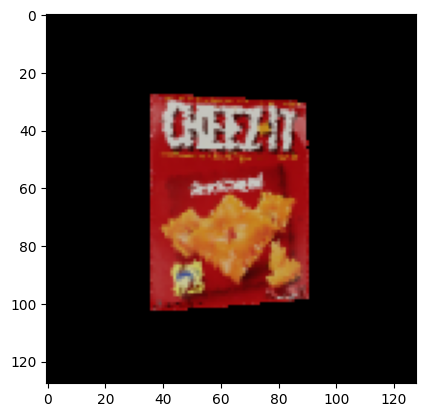

In [41]:
plt.imshow(new_tr['observed_rgb_depth_0'][0])

In [33]:
enum

[Array([8354.871, 8340.047], dtype=float32),
 Array([8349.484, 8319.498], dtype=float32),
 Array([8349.393, 8305.865], dtype=float32),
 Array([8350.1  , 8322.137], dtype=float32),
 Array([8348.025, 8348.025], dtype=float32),
 Array([8346.022, 8346.022], dtype=float32),
 Array([8347.133, 8347.133], dtype=float32),
 Array([8345.352, 8345.352], dtype=float32),
 Array([8345.168, 8345.168], dtype=float32),
 Array([8343.79, 8343.79], dtype=float32),
 Array([8343.6875, 8343.6875], dtype=float32),
 Array([8342.113, 8342.113], dtype=float32),
 Array([8339.056, 8339.056], dtype=float32),
 Array([8336.477, 8336.477], dtype=float32),
 Array([8335.979, 8335.979], dtype=float32),
 Array([8333.905, 8333.905], dtype=float32),
 Array([8330.629, 8330.629], dtype=float32),
 Array([8327.307, 8327.307], dtype=float32),
 Array([8325.375, 8325.375], dtype=float32),
 Array([8324.381, 8324.381], dtype=float32),
 Array([8324.691, 8324.691], dtype=float32),
 Array([8325.4795, 8325.4795], dtype=float32),
 Array([

In [32]:
enum

[Array([8357.371, 8345.047], dtype=float32),
 Array([8351.984, 8324.498], dtype=float32),
 Array([8351.893, 8310.865], dtype=float32),
 Array([8352.6  , 8327.137], dtype=float32),
 Array([8350.525, 8353.025], dtype=float32),
 Array([8348.522, 8351.022], dtype=float32),
 Array([8349.633, 8352.133], dtype=float32),
 Array([8347.852, 8350.352], dtype=float32),
 Array([8347.668, 8350.168], dtype=float32),
 Array([8346.29, 8348.79], dtype=float32),
 Array([8346.1875, 8348.6875], dtype=float32),
 Array([8344.613, 8347.113], dtype=float32),
 Array([8341.556, 8344.056], dtype=float32),
 Array([8338.977, 8341.477], dtype=float32),
 Array([8338.479, 8340.979], dtype=float32),
 Array([8336.405, 8338.905], dtype=float32),
 Array([8333.129, 8335.629], dtype=float32),
 Array([8329.807, 8332.307], dtype=float32),
 Array([8327.875, 8330.375], dtype=float32),
 Array([8326.881, 8329.381], dtype=float32),
 Array([8327.191, 8329.691], dtype=float32),
 Array([8327.9795, 8330.4795], dtype=float32),
 Array([

In [ ]:
# redo this experiment with outlier branch coloring in visualization!

In [44]:
key = jax.random.PRNGKey(0)


center_arr = []
center_vis = []
for i in np.arange(35,100,40): #10
    row_arr = []
    row_vis = [1] # hardcoded first frame visible
    for j in np.arange(45,90,30): #10
        _, patch_centers, _, enum = get_trajs(key, i, j)
        row_arr.append(patch_centers)
        row_vis.append([1] + jnp.array(enum).argmax(axis=1))
    center_arr.append(row_arr)
    center_vis.append(row_vis)

100%|██████████| 29/29 [00:12<00:00,  2.42it/s]


In [51]:
center_vis[0][1]

Array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [45]:
center_arr = jnp.array(center_arr)
center_arr = center_arr.reshape(-1,len(xyzs),3)

center_vis = jnp.array(center_vis)
center_vis = center_vis.reshape(-1,len(xyzs))

ValueError: All input arrays must have the same shape.

In [ ]:
center_vis.shape

In [27]:
num_points = center_arr.shape[0]

for t in range(len(xyzs)):
    rr.set_time_sequence("frame", t)

    indices = xyzs[t,...,2] < far
    points = rr.Points3D(xyzs[t,indices,:].reshape(-1,3), colors=rgbs[t,indices,:].reshape(-1,3), radii = 0.0005*np.ones(xyzs[t,indices,:].reshape(-1,3).shape[0]))
    rr.log("cloud1", points)

    points2 = rr.Points3D(center_arr[:,t,:], radii=0.0075*np.ones(center_arr.shape[0]), colors =np.repeat(np.array([0,0,255])[None,...], num_points, axis=0))
    rr.log("cloud2", points2)

    num_frames_trail = 5
    if t > num_frames_trail:
        rr.log(
            "strips",
            rr.LineStrips3D(np.array(center_arr[:,t:t-num_frames_trail:-1,...]), colors=np.repeat(np.array([0,255,0])[None,...], num_points, axis=0), 
            radii= 0.0025*np.ones(num_points))
        )

In [28]:
# tightening the physics
# move get_trajs out so it's jittable end to end 

# tracking doesn't quite work, possibly tracing the wrong thing or the initial setup is wrong

In [31]:
# compare turn right, then turn back left
# try on real